In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, utils, metrics

2024-07-18 14:43:55.622393: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-18 14:43:55.644456: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 14:43:55.644485: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 14:43:55.644498: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-18 14:43:55.648946: I tensorflow/core/platform/cpu_feature_g

In [3]:
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 100
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

In [4]:
# 데이터셋인 레고 이미지는 https://oreil.ly/3vp9f 에서 직접 다운로드 받았습니다.

train_data = utils.image_dataset_from_directory(
    './dataset/',
    labels=None,
    color_mode='grayscale',
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE,
    shuffle = True,
    seed= 42,
    interpolation = 'bilinear',
)

Found 40000 files belonging to 1 classes.


2024-07-18 14:45:11.998489: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-18 14:45:12.022775: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-18 14:45:12.022807: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-18 14:45:12.025275: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-18 14:45:12.025306: I tensorflow/compile

In [5]:
# 데이터를 전처리 합니다.
def preprocess_image(img):
    img = (tf.cast(img, 'float32') - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess_image(x))

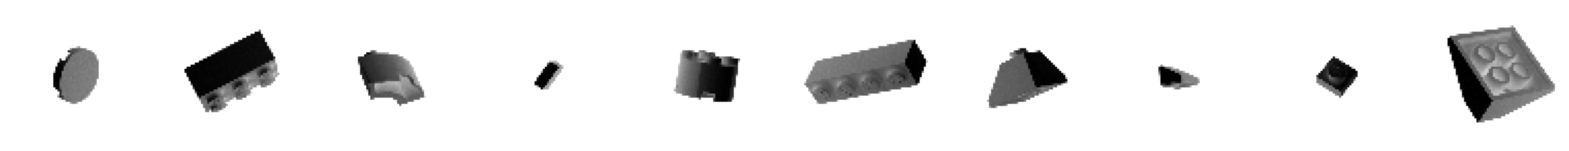

In [6]:
# 이미지를 예시로 몇개 출력합니다.
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display( images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None):
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()


train_sample = sample_batch(train)
display(train_sample)

### 판별자(Discriminator)

판별자의 목표는 이미지가 진짜인지 가짜인지 예측하는 것.  
이는 지도 학습의 이미지 분류 문제이므로 ch2의 합성곱 층으로 구현할 수 있습니다. 

In [7]:
discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding='same', use_bias=False)(discriminator_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(256, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(512, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

# 마지막 합성곱 층의 출력을 펼친다. 이 때, 텐서의 크기는 1x1x1이므로 마지막 Dense 층이 필요하지 않다.
x = layers.Conv2D(1, kernel_size=4, strides=1, padding='valid', use_bias=False, activation='sigmoid')(x)

discriminator_output = layers.Flatten()(x)

discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization (Batch  (None, 16, 16, 128)       512       
 Normalization)                                                  
                                                             

### 생성자(Generator)

생성자의 입력은 다변량 표준 정규 분포에서 뽑은 벡터.  
출력은 훈련 데이터에 있는 이미지와 동일한 크기의 이미지.


In [8]:
# Input 층 = 길이가 100인 벡터
generator_input = layers.Input(shape=(Z_DIM,))

# 전치 합성곱 층을 적용하기 위해 Input 층을 1x1x100 크기의 텐서로 변환
x= layers.Reshape((1, 1, Z_DIM))(generator_input)

x = layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding='valid', use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

generator_output = layers.Conv2DTranspose(1, kernel_size=4, strides=2, padding='same', use_bias=False, activation='tanh')(x)
generator = models.Model(generator_input, generator_output)

generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 512)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_3 (Bat  (None, 4, 4, 512)         2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 8, 8, 256)         2097

## DCGAN 훈련

DCGAN의 생성자, 판별자의 구조는 3장의 VAE와 크게 다르지 않으며 단순합니다.  
GAN의 핵심은 훈련 과정에 있습니다. 훈련 데이터의 진짜 샘플과 생성자의 출력을 합쳐 새로운 훈련 데이터를 만듭니다.  
이를 지도 학습 문제로 다루며 진짜 이미지의 label = 1, 가짜 이미지의 label = 0 입니다. 이를 통해 판별자를 학습시킵니다.  

생성자는 생성한 이미지에 점수를 부여하고 높은 점수를 낸 이미지로 최적화하는 방법을 찾습니다.  
이 때, 생성한 이미지의 점수는 판별자가 0~1 사이의 점수를 출력하므로 이를 사용할 수 있습니다.  

한 번에 한 네트워크의 가중치만을 업데이트되도록 생성자와 판별자를 번갈아 훈련하는 것이 중요합니다.  
동시에 업데이트하게 되면 생성자가 좋은 이미지를 생성하여 판별자를 속이는 것이 아닌 판별자가 판별을 못 해서 좋은 점수가 나오게 될 수 있기 때문입니다.  

In [9]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.g_acc_metric = None
        self.d_acc_metric = None
        self.d_fake_acc_metric = None
        self.d_real_acc_metric = None
        self.g_loss_metric = None
        self.d_loss_metric = None
        self.g_optimizer = None
        self.d_optimizer = None
        self.loss_fn = None
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        
    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name='d_loss')
        self.g_loss_metric = metrics.Mean(name='g_loss')
        self.d_real_acc_metric = metrics.BinaryAccuracy(name='d_real_acc')
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name='d_fake_acc')
        self.d_acc_metric = metrics.Accuracy(name='d_acc')
        self.g_acc_metric = metrics.Accuracy(name='g_acc')
        
    @property
    def metrics(self):
        return [self.d_loss_metric, 
                self.d_real_acc_metric, 
                self.d_fake_acc_metric,
                self.d_acc_metric,
                self.g_loss_metric, 
                self.g_acc_metric,
        ]
    
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        
        # 가짜 이미지로 판별자 훈련
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(generated_images, training=True)
            
            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(tf.shape(real_predictions))
            
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels + NOISE_PARAM * tf.random.uniform(tf.shape(fake_predictions))
            
            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss)/2
            g_loss = self.loss_fn(real_labels, fake_predictions)
        
        gradients_of_discriminator = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)
        gradients_of_generator = gen_tape.gradient(g_loss, self.generator.trainable_variables)
        
        self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        self.g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        
        return {m.name: m.result() for m in self.metrics}

In [10]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=Z_DIM)

In [11]:
d_opt = optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2)
g_opt = optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2)
dcgan.compile(d_optimizer=d_opt, g_optimizer=g_opt,)

In [12]:
dcgan.fit(train, epochs=EPOCHS)

Epoch 1/100


2024-07-18 14:48:45.254420: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-07-18 14:48:45.830218: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-07-18 14:48:46.129493: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-18 14:48:47.780898: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f71ed639260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-18 14:48:47.780930: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-07-18 14:48:47.789122: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set 

313/313 [==============================] - 19s 46ms/step - d_loss: 0.4445 - d_real_acc: 0.0000e+00 - d_fake_acc: 0.0000e+00 - d_acc: 0.0000e+00 - g_loss: 2.3586 - g_acc: 0.0000e+00
Epoch 2/100
313/313 [==============================] - 12s 37ms/step - d_loss: 0.2419 - d_real_acc: 0.0000e+00 - d_fake_acc: 0.0000e+00 - d_acc: 0.0000e+00 - g_loss: 2.7468 - g_acc: 0.0000e+00
Epoch 3/100
313/313 [==============================] - 12s 39ms/step - d_loss: 0.2499 - d_real_acc: 0.0000e+00 - d_fake_acc: 0.0000e+00 - d_acc: 0.0000e+00 - g_loss: 2.8272 - g_acc: 0.0000e+00
Epoch 4/100
313/313 [==============================] - 12s 37ms/step - d_loss: 0.2646 - d_real_acc: 0.0000e+00 - d_fake_acc: 0.0000e+00 - d_acc: 0.0000e+00 - g_loss: 2.6670 - g_acc: 0.0000e+00
Epoch 5/100
313/313 [==============================] - 13s 39ms/step - d_loss: 0.2772 - d_real_acc: 0.0000e+00 - d_fake_acc: 0.0000e+00 - d_acc: 0.0000e+00 - g_loss: 2.5879 - g_acc: 0.0000e+00
Epoch 6/100
313/313 [==========================

In [13]:
generator.save('./models/generator')
discriminator.save('./models/discriminator')

INFO:tensorflow:Assets written to: ./models/generator/assets


INFO:tensorflow:Assets written to: ./models/generator/assets


INFO:tensorflow:Assets written to: ./models/discriminator/assets


INFO:tensorflow:Assets written to: ./models/discriminator/assets


### 새로운 이미지 생성

In [14]:
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [15]:
reconstructions = generator.predict(z_sample)

1/1 [==============================] - 1s 540ms/step


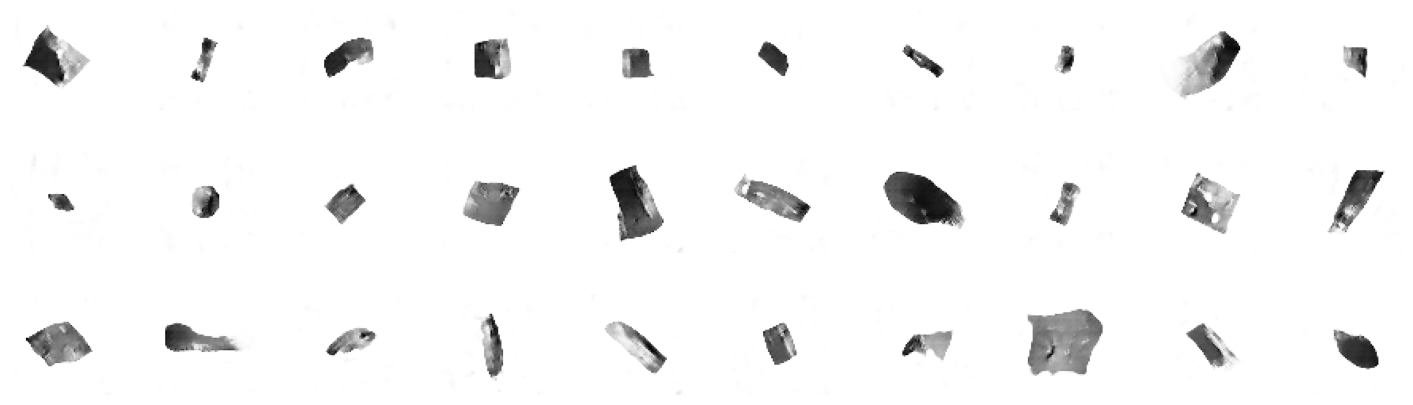

In [16]:
# 디코딩된 이미지 그리기
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# 얼굴 그리드 출력
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")